In [1]:
import os
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import tqdm
from skimage import io

cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd
else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break
sys.path.append(str(root_dir / "utils"))
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

In [2]:
def convert_indexed_mask_to_binary_mask(indexed_mask: np.ndarray) -> np.ndarray:
    """
    Convert an indexed mask to a binary mask.

    Parameters
    ----------
    indexed_mask : np.ndarray
        An indexed mask where 0 represents the background and any positive integer represents a different object.

    Returns
    -------
    np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.
    """
    binary_mask = np.zeros_like(indexed_mask, dtype=bool)
    binary_mask[indexed_mask > 0] = True
    return binary_mask


def extract_IOU(mask1: np.ndarray, mask2: np.ndarray) -> float:
    """
    Calculate the Intersection over Union (IoU) between two binary masks.

    Parameters
    ----------
    mask1 : np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.
    mask2 : np.ndarray
        A binary mask where True represents the foreground (objects) and False represents the background.

    Returns
    -------
    float
        The Intersection over Union (IoU) score between the two masks.
    """
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score.item()

In [3]:
if not in_notebook:
    args = parse_args()
    window_size = args["window_size"]
    clip_limit = args["clip_limit"]
    well_fov = args["well_fov"]
    patient = args["patient"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        window_size=window_size,
        clip_limit=clip_limit,
    )
else:
    print("Running in a notebook")
    patient = "NF0014_T1"
    well_fov = "C4-2"
    window_size = 3
    clip_limit = 0.05


input_dir_raw = pathlib.Path(
    f"{image_base_dir}/data/{patient}/zstack_images/{well_fov}"
).resolve(strict=True)
input_dir_decon = pathlib.Path(
    f"{image_base_dir}/data/{patient}/deconvolved_images/{well_fov}"
).resolve(strict=True)

Running in a notebook


In [4]:
# get the segmentation masks
masks_dict = {}

# get the files in mask_path_raw
mask_files = sorted(input_dir_decon.glob("*.tiff"))
mask_files = [x for x in mask_files if "mask" in x.stem]
for mask_file in mask_files:
    mask = tifffile.imread(mask_file)
    if "organoid" in mask_file.stem and "raw" in mask_file.stem:
        masks_dict["organoid"]["raw"] = mask
    else:
        masks_dict[f"raw_{mask_file.stem}"] = mask
for mask_file in sorted(input_dir_raw.glob("*.tiff")):
    mask = tifffile.imread(mask_file)
    masks_dict[f"decon_{mask_file.stem}"] = mask

In [5]:
masks_dict.keys()

dict_keys(['raw_cell_masks', 'raw_cytoplasm_masks', 'raw_nuclei_masks', 'raw_organoid_masks', 'decon_cell_masks', 'decon_cytoplasm_masks', 'decon_nuclei_masks', 'decon_organoid_masks'])

In [15]:
# anchor the decon as the comparator
dict_of_compartments = {
    "organoid": {
        "decon": [masks_dict["decon_organoid_masks"]],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "nuclei": {
        "decon": [masks_dict["decon_nuclei_masks"]],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "cell": {
        "decon": [masks_dict["decon_cell_masks"]],
        "all_other_masks": [],
        "all_other_labels": [],
    },
    "cytoplasm": {
        "decon": [masks_dict["decon_cytoplasm_masks"]],
        "all_other_masks": [],
        "all_other_labels": [],
    },
}
for key in masks_dict.keys():
    if "decon" not in key:
        if "organoid" in key:
            dict_of_compartments["organoid"]["all_other_masks"].append(masks_dict[key])
            dict_of_compartments["organoid"]["all_other_labels"].append(key)
        elif "nuclei" in key:
            dict_of_compartments["nuclei"]["all_other_masks"].append(masks_dict[key])
            dict_of_compartments["nuclei"]["all_other_labels"].append(key)
        elif "cell" in key:
            dict_of_compartments["cell"]["all_other_masks"].append(masks_dict[key])
            dict_of_compartments["cell"]["all_other_labels"].append(key)
        elif "cytoplasm" in key:
            dict_of_compartments["cytoplasm"]["all_other_masks"].append(masks_dict[key])
            dict_of_compartments["cytoplasm"]["all_other_labels"].append(key)

In [9]:
for compartment in dict_of_compartments.keys():
    decon_mask = dict_of_compartments[compartment]["decon"][0]
    for other_mask in dict_of_compartments[compartment]["all_other"]:
        iou_score = extract_IOU(
            convert_indexed_mask_to_binary_mask(decon_mask),
            convert_indexed_mask_to_binary_mask(other_mask),
        )
        print(f"IoU score for {compartment} between decon and other: {iou_score:.4f}")

IoU score for organoid between decon and other: 0.9109
IoU score for nuclei between decon and other: 0.0013
IoU score for cell between decon and other: 0.0000
IoU score for cytoplasm between decon and other: 0.0000


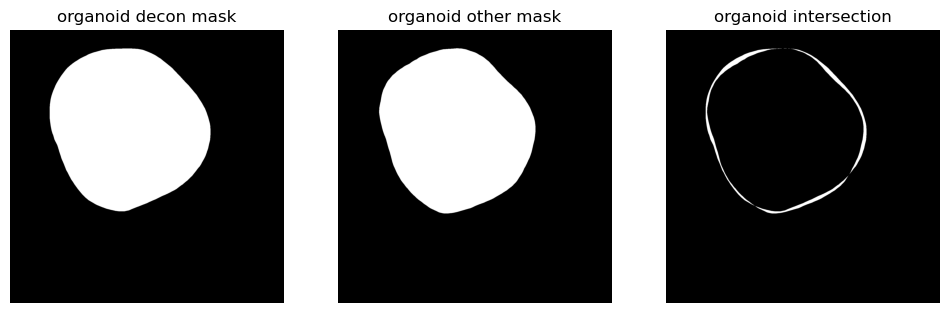

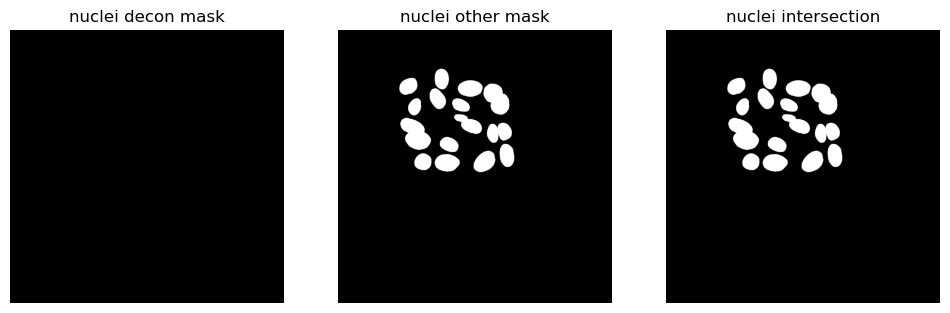

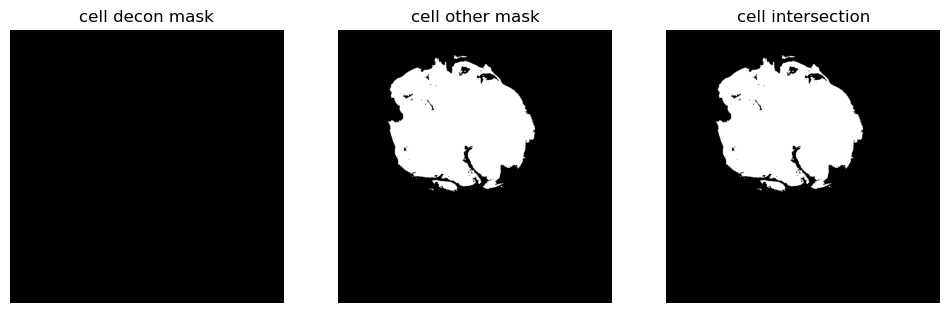

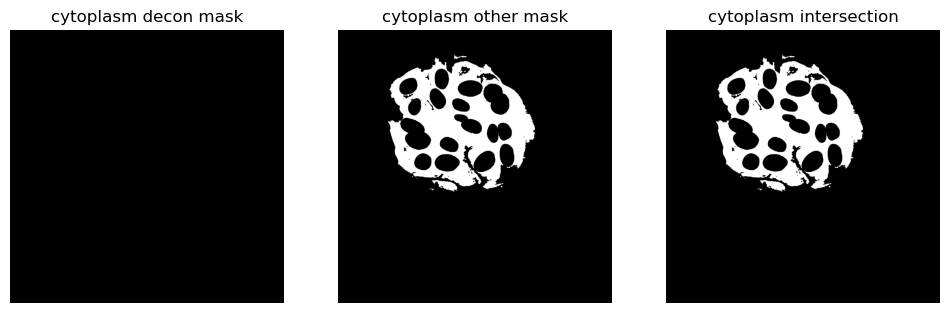

In [23]:
for compartment in dict_of_compartments.keys():
    decon_mask = convert_indexed_mask_to_binary_mask(
        dict_of_compartments[compartment]["decon"][0]
    )
    for other_mask in dict_of_compartments[compartment]["all_other_masks"]:
        other_mask = convert_indexed_mask_to_binary_mask(other_mask)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"{compartment} decon mask")
        plt.imshow(decon_mask[decon_mask.shape[0] // 2], cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"{compartment} other mask")
        plt.imshow(other_mask[other_mask.shape[0] // 2], cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title(f"{compartment} intersection")
        plt.imshow(
            np.logical_xor(decon_mask, other_mask)[decon_mask.shape[0] // 2],
            cmap="gray",
        )
        plt.axis("off")
        plt.show()